In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score

### We dont know true cluster labels. In this case we can use [Silhouette Coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for calculating score of clusterization. The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters.

In [50]:
COLUMNS_TO_DROP = ['_id', 'year', 'n_citation', 'references', 'authors']
NUM_PARTS = 3
RANDOM_STATE = 42
REDUCED_DIMENSION = 100
NUM_CLUSTERS = 50

def plot_clusters(cluster_ids, cluster_sizes):
    plt.figure(figsize=(18, 7))
    plt.bar(cluster_ids, cluster_sizes)
    plt.xlabel('Cluster id')
    plt.title('Cluster sizes')
    plt.show()

def get_score(X, cluster_labels, sample_size=10000):
    return silhouette_score(X, pipe['kmeans'].labels_, sample_size=sample_size, random_state=RANDOM_STATE)

def get_text_data(file_path):
    data = pd.read_json('data/part_1_clean.json', dtype={'title': 'string', 'abstract': 'string'}).drop(COLUMNS_TO_DROP, axis=1)
    data['keywords'] = data['keywords'].apply(lambda row: ' '.join(row)).astype('string')
    data['fos'] = data['fos'].apply(lambda row: ' '.join(row)).astype('string')
    data['venue'] = data['venue'].apply(lambda row: row.get('name_d', '')).astype('string')
    
    data['text'] = data.apply(lambda row: ' '.join(row.astype(str)), axis=1).astype('string')
    data.drop(['title', 'abstract', 'venue'], axis=1, inplace=True)
    return data

In [51]:
part1 = get_text_data('data/part_1_clean.json')

In [52]:
part1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 511602 entries, 0 to 511601
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   keywords  511602 non-null  string
 1   fos       511602 non-null  string
 2   text      511602 non-null  string
dtypes: string(3)
memory usage: 15.6 MB


### Time consuming cell below: 3 parts are loaded, transformed and concatenated together.

In [57]:
articles = pd.concat(get_text_data(f'data/part_{i}_clean.json') for i in range(NUM_PARTS))
articles.reset_index(drop=True, inplace=True)
articles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1534806 entries, 0 to 511601
Data columns (total 3 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   keywords  1534806 non-null  string
 1   fos       1534806 non-null  string
 2   text      1534806 non-null  string
dtypes: string(3)
memory usage: 46.8 MB


In [65]:
articles

,keywords,fos,text
0,handwriting recognition prototypes image segme...,Intelligent character recognition Pattern reco...,A solution to the problem of touching and brok...
1,sequential circuits statistical distributions ...,Delay calculation Timing failure Monte Carlo m...,Timing yield estimation using statistical stat...
2,Internet hypermedia markup languages informati...,XML Base World Wide Web XML framework XML Encr...,Using XML to Integrate Existing Software Syste...
3,cognition multi-agent systems ubiquitous compu...,Syma Computer science Symbiotic computing Mult...,The design of awareness and operation module f...
4,balanced scorecard,Lease Computer science Balanced scorecard Busi...,A Model for Evaluating the Effectiveness of th...
...,...,...,...
1534801,data mining probability density function montg...,Integer Cryptography Modular arithmetic Parall...,Modular Reduction without Precomputational Pha...
1534802,particle filters video tracking data fusion in...,Computer vision Space technology Identifier In...,Video-radio fusion approach for target trackin...
1534803,visualization load balancing parallel processi...,Computer architecture Visualization Load balan...,Survey of parallel approaches to scientific vi...
1534804,parallel distributed compensation scheme lyapu...,Lyapunov function Stability criterion Mathemat...,Stability Analysis of Time-Delay Fuzzy Systems...


In [66]:
vectorizer = TfidfVectorizer(max_df=0.1, min_df=5, stop_words='english')
svd = TruncatedSVD(n_components=REDUCED_DIMENSION, random_state=RANDOM_STATE)
kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=RANDOM_STATE)

pipe = Pipeline([
    ('tfidf', vectorizer),
    ('svd', svd),
    ('kmeans', kmeans)
])

In [67]:
pipe.fit(articles.text)

cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)

In [79]:
articles_compressed = pipe[:-1].transform(articles.text)
print(articles_compressed.shape)

(1534806, 100)


In [69]:
print('Score:', get_score(articles_compressed, kmeans.labels_))

Score: 0.11644531182964452


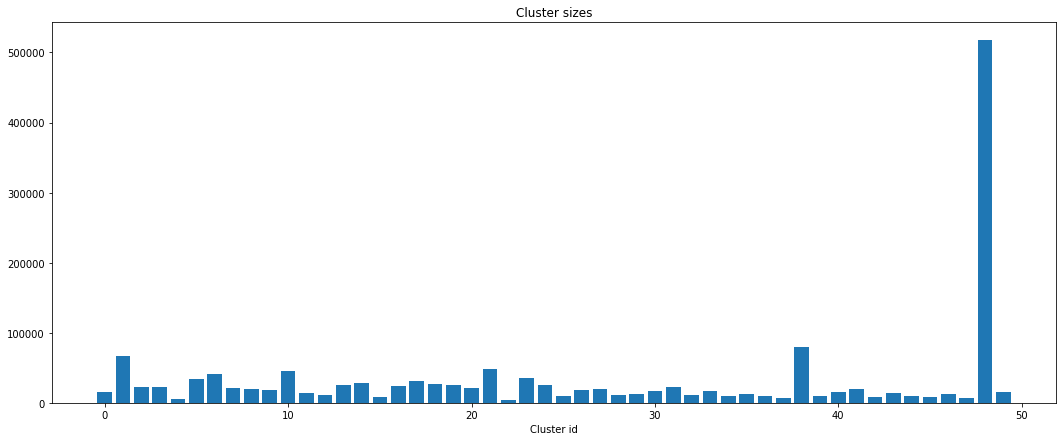

In [70]:
plot_clusters(cluster_ids, cluster_sizes)

In [80]:
original_space_centroids = svd.inverse_transform(kmeans.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

topK = 10
for i in range(NUM_CLUSTERS):
    print(f'Cluster {i}: ', end='')
    print(' '.join(terms[order_centroids[i, :topK]]))

Cluster 0: agent multi agents intelligent architecture mobile autonomous environment multiagent human
Cluster 1: linear filter matrix noise signal nonlinear estimation adaptive function stability
Cluster 2: sensor wireless energy key fusion node mobile sensors distribution nodes
Cluster 3: web semantic world wide services service page internet pages search
Cluster 4: xml document schema documents database query structure interchange validation efficient
Cluster 5: power circuit cmos circuits voltage integrated low electronic chip electronics
Cluster 6: feature classification extraction vector face support selection detection classifier features
Cluster 7: video coding motion compression quality multimedia rate tracking frame content
Cluster 8: fuzzy logic neuro sets classification membership defuzzification neural inference adaptive
Cluster 9: logic temporal probabilistic semantics modal reasoning gate logics calculus synthesis
Cluster 10: traffic wireless multicast packet protocol int